In [1]:
%matplotlib inline
import keras
import numpy as np 
import spacy
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_vectors_web_lg')

## Dataset can be downloaded from [here](https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis/data)

In [3]:
connection = sqlite3.connect('../data/database.sqlite')

Let's load data with score other than 3, and label rest as *positive* or *negative*

In [4]:
import re

messages = pd.read_sql_query("""
SELECT Score, lower(Summary) as Summary
FROM Reviews
WHERE Score != 3
LIMIT 5000
""", connection)

def clear_text(text):
    only_alpha_regex = re.compile(r'[^\w+ ]')
    return only_alpha_regex.sub('', text)
    

messages['Label'] = messages.apply(lambda x: int(x['Score'] > 3), axis=1)
messages['Summary'] = messages['Summary'].apply(clear_text)
messages.head()

,Score,Summary,Label
0,5,good quality dog food,1
1,1,not as advertised,0
2,4,delight says it all,1
3,2,cough medicine,0
4,5,great taffy,1


### data analysis

Text(0,0.5,'Frequency')

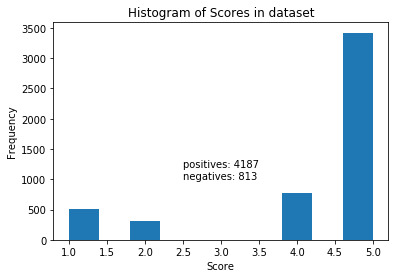

In [5]:
plt.hist(messages.Score)
plt.title('Histogram of Scores in dataset')
plt.text(2.5, 1000, 'positives: {}\nnegatives: {}'.format(*messages.Label.value_counts().values))
plt.xlabel('Score')
plt.ylabel('Frequency')

### Models

In [6]:
from sklearn.cross_validation import train_test_split

X = np.array([nlp(m).vector for m in messages['Summary']])
y = messages.Label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.model_selection import cross_val_score
from plot_helpers import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

def check_model(name, model):
    fitted_model = model.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_test)
    classes = ['Negative', 'Positive']
    print("Classification report for {}\n".format(name))
    print(classification_report(y_test, y_pred, target_names=classes))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes)

    scores = cross_val_score(model, X, y, cv=4, n_jobs=-1, scoring='roc_auc')
    print("cross-validated ROC AUC for %s: %0.4f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2))

Classification report for Dummy - most frequent class

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00       200
   Positive       0.84      1.00      0.91      1050

avg / total       0.71      0.84      0.77      1250



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cross-validated ROC AUC for Dummy - most frequent class: 0.5000 (+/- 0.0000)


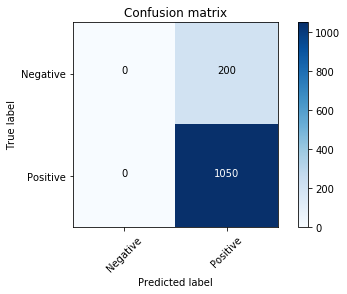

In [8]:
from sklearn.dummy import DummyClassifier
check_model('Dummy - most frequent class', DummyClassifier('most_frequent'))

Classification report for KNeighbours

             precision    recall  f1-score   support

   Negative       0.78      0.40      0.53       200
   Positive       0.90      0.98      0.94      1050

avg / total       0.88      0.89      0.87      1250

cross-validated ROC AUC for KNeighbours: 0.8210 (+/- 0.0390)


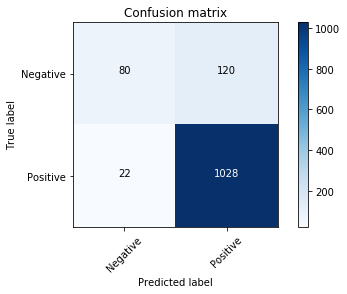

In [9]:
from sklearn.neighbors import KNeighborsClassifier
check_model('KNeighbours', KNeighborsClassifier(5))

Classification report for Linear SVC

             precision    recall  f1-score   support

   Negative       0.88      0.40      0.54       200
   Positive       0.90      0.99      0.94      1050

avg / total       0.89      0.89      0.88      1250

cross-validated ROC AUC for Linear SVC: 0.9163 (+/- 0.0251)


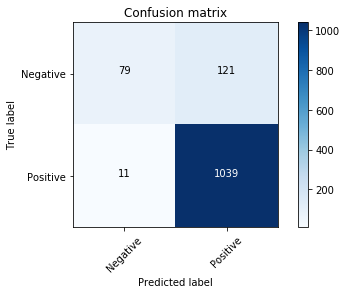

In [10]:
from sklearn.svm import SVC
check_model('Linear SVC', SVC(kernel="linear", C=0.025))

Classification report for SVC

             precision    recall  f1-score   support

   Negative       0.86      0.09      0.16       200
   Positive       0.85      1.00      0.92      1050

avg / total       0.85      0.85      0.80      1250

cross-validated ROC AUC for SVC: 0.8315 (+/- 0.0376)


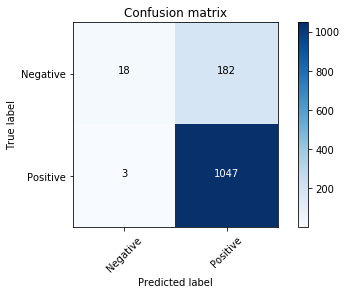

In [11]:
from sklearn.svm import SVC
check_model('SVC', SVC(gamma=2, C=1))

Classification report for DecisionTreeClassifier

             precision    recall  f1-score   support

   Negative       0.45      0.47      0.46       200
   Positive       0.90      0.89      0.89      1050

avg / total       0.83      0.82      0.82      1250

cross-validated ROC AUC for DecisionTreeClassifier: 0.6742 (+/- 0.0321)


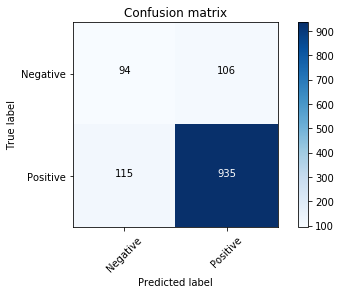

In [12]:
from sklearn.tree import DecisionTreeClassifier
check_model('DecisionTreeClassifier', DecisionTreeClassifier())

Classification report for RandomForest

             precision    recall  f1-score   support

   Negative       0.58      0.41      0.49       200
   Positive       0.89      0.94      0.92      1050

avg / total       0.84      0.86      0.85      1250

cross-validated ROC AUC for RandomForest: 0.8387 (+/- 0.0200)


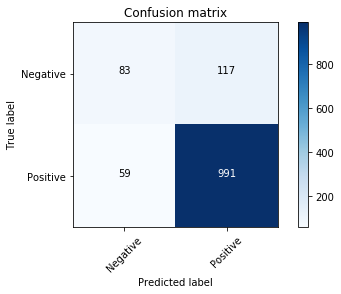

In [13]:
from sklearn.ensemble import RandomForestClassifier
check_model('RandomForest', RandomForestClassifier())

Classification report for NeuralNet

             precision    recall  f1-score   support

   Negative       0.74      0.63      0.68       200
   Positive       0.93      0.96      0.94      1050

avg / total       0.90      0.91      0.90      1250

cross-validated ROC AUC for NeuralNet: 0.8968 (+/- 0.0200)


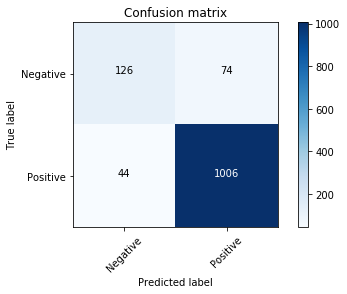

In [14]:
from sklearn.neural_network import MLPClassifier
check_model('NeuralNet', MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500))

Classification report for NaiveBayes

             precision    recall  f1-score   support

   Negative       0.36      0.84      0.50       200
   Positive       0.96      0.71      0.82      1050

avg / total       0.86      0.73      0.77      1250

cross-validated ROC AUC for NaiveBayes: 0.8722 (+/- 0.0300)


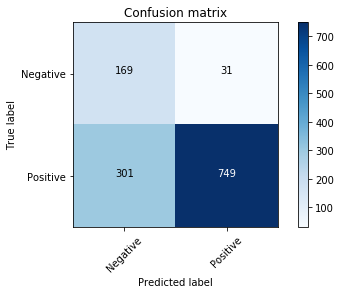

In [15]:
from sklearn.naive_bayes import GaussianNB
check_model('NaiveBayes', GaussianNB())

Classification report for AdaBoostClassifier

             precision    recall  f1-score   support

   Negative       0.65      0.53      0.59       200
   Positive       0.91      0.95      0.93      1050

avg / total       0.87      0.88      0.87      1250

cross-validated ROC AUC for AdaBoostClassifier: 0.8862 (+/- 0.0358)


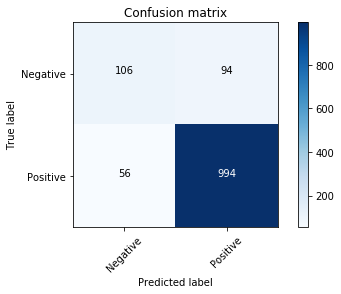

In [16]:
from sklearn.ensemble import AdaBoostClassifier
check_model('AdaBoostClassifier', AdaBoostClassifier())

Classification report for QuadraticDiscriminantAnalysis

             precision    recall  f1-score   support

   Negative       0.49      0.34      0.41       200
   Positive       0.88      0.93      0.91      1050

avg / total       0.82      0.84      0.83      1250

cross-validated ROC AUC for QuadraticDiscriminantAnalysis: 0.7078 (+/- 0.0660)


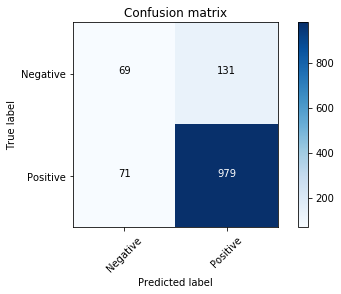

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
check_model('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis())

Classification report for LogisticRegression

             precision    recall  f1-score   support

   Negative       0.72      0.59      0.65       200
   Positive       0.92      0.96      0.94      1050

avg / total       0.89      0.90      0.89      1250

cross-validated ROC AUC for LogisticRegression: 0.8853 (+/- 0.0337)


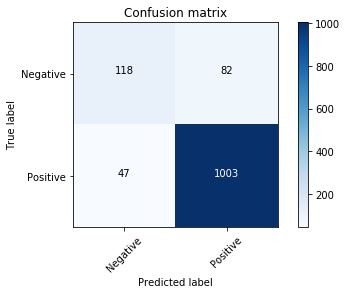

In [18]:
from sklearn.linear_model import LogisticRegression
check_model('LogisticRegression', LogisticRegression(C=1e5))

Classification report for GradientBoostingClassifier

             precision    recall  f1-score   support

   Negative       0.81      0.56      0.67       200
   Positive       0.92      0.98      0.95      1050

avg / total       0.90      0.91      0.90      1250

cross-validated ROC AUC for GradientBoostingClassifier: 0.9129 (+/- 0.0127)


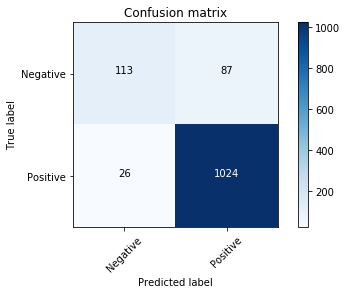

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
check_model('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=500, max_depth=2))